# 1 - Object Detection
## 1.1) Haar Cascade

The Haar feature-based cascade classifier is an effective object detection method proposed by Viola and Jones. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. [1]

Initially, the algorithm needs a lot of positive images and negative images to train the classifier. Then we need to extract features from it. For this, Haar features shown in the below image are used. They are just like our convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle. [1]

<center>
    <figure style="margin-top:20px">
        <img src="https://docs.opencv.org/2.4/_images/haarfeatures.png">
        <figcaption style="margin-top:20px">Figura 1 - Kind of features [2].</figcaption>
    </figure>
</center>

Instead of applying all features on a window, the features are grouped into different stages of classifiers and applied one-by-one. (Normally the first few stages will contain very many fewer features). If a window fails the first stage, discard it. We don't consider the remaining features on it. If it passes, apply the second stage of features and continue the process.

Now, let's discover how to use this classifier with OpenCV. 

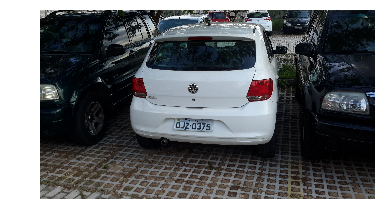

In [93]:
# Importing OpenCV library
import cv2

# Importing library to show our images
from matplotlib import pyplot as plt

# Importing library to manipulate our images
import numpy as np

from math import sqrt

# Loading our image
car = cv2.imread('images/car.jpg')
car_gray = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)

# Showing our image
plt.figure()
plt.axis("off")
plt.imshow(car)
plt.show()

Initially, we need to load a classifier:

<center>
    <strong>cv2.CascadeClassifier([filename]) → Classifier Object </strong>
</center>

where:

<ul>
    <li><i>filename</i> – Name of the file from which the classifier is loaded.</li>
</ul>

In [74]:
# Loading our classifier
plates_classifier = cv2.CascadeClassifier('classifiers/plates.xml')

After that, we should use the following function to try to classify the object: 

<center>
    <strong>*name_of_classifier*.detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) → objects </strong>
</center>

where:

<ul>
    <li><i>image</i> – Matrix of the type CV_8U containing an image where objects are detected..</li>
    <li><i>scaleFactor</i> – Parameter specifying how much the image size is reduced at each image scale.</li>
    <li><i>minNeighbors</i> – Parameter specifying how many neighbors each candidate rectangle should have to retain it.</li>
    <li><i>flags</i> – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.</li>
    <li><i>minSize</i> – Minimum possible object size. Objects smaller than that are ignored.</li>
    <li><i>maxSize</i> – Maximum possible object size. Objects larger than that are ignored.</li>
    <li><i>objects</i> – Vector of rectangles where each rectangle contains the detected object.</li>
</ul>

In [75]:
min_width = car.shape[1] * 0.045

# Detecting out plates
plates = plates_classifier.detectMultiScale(car_gray, 1.1, 4)

Now, we only need to isolate the rectangles which contain the objects.

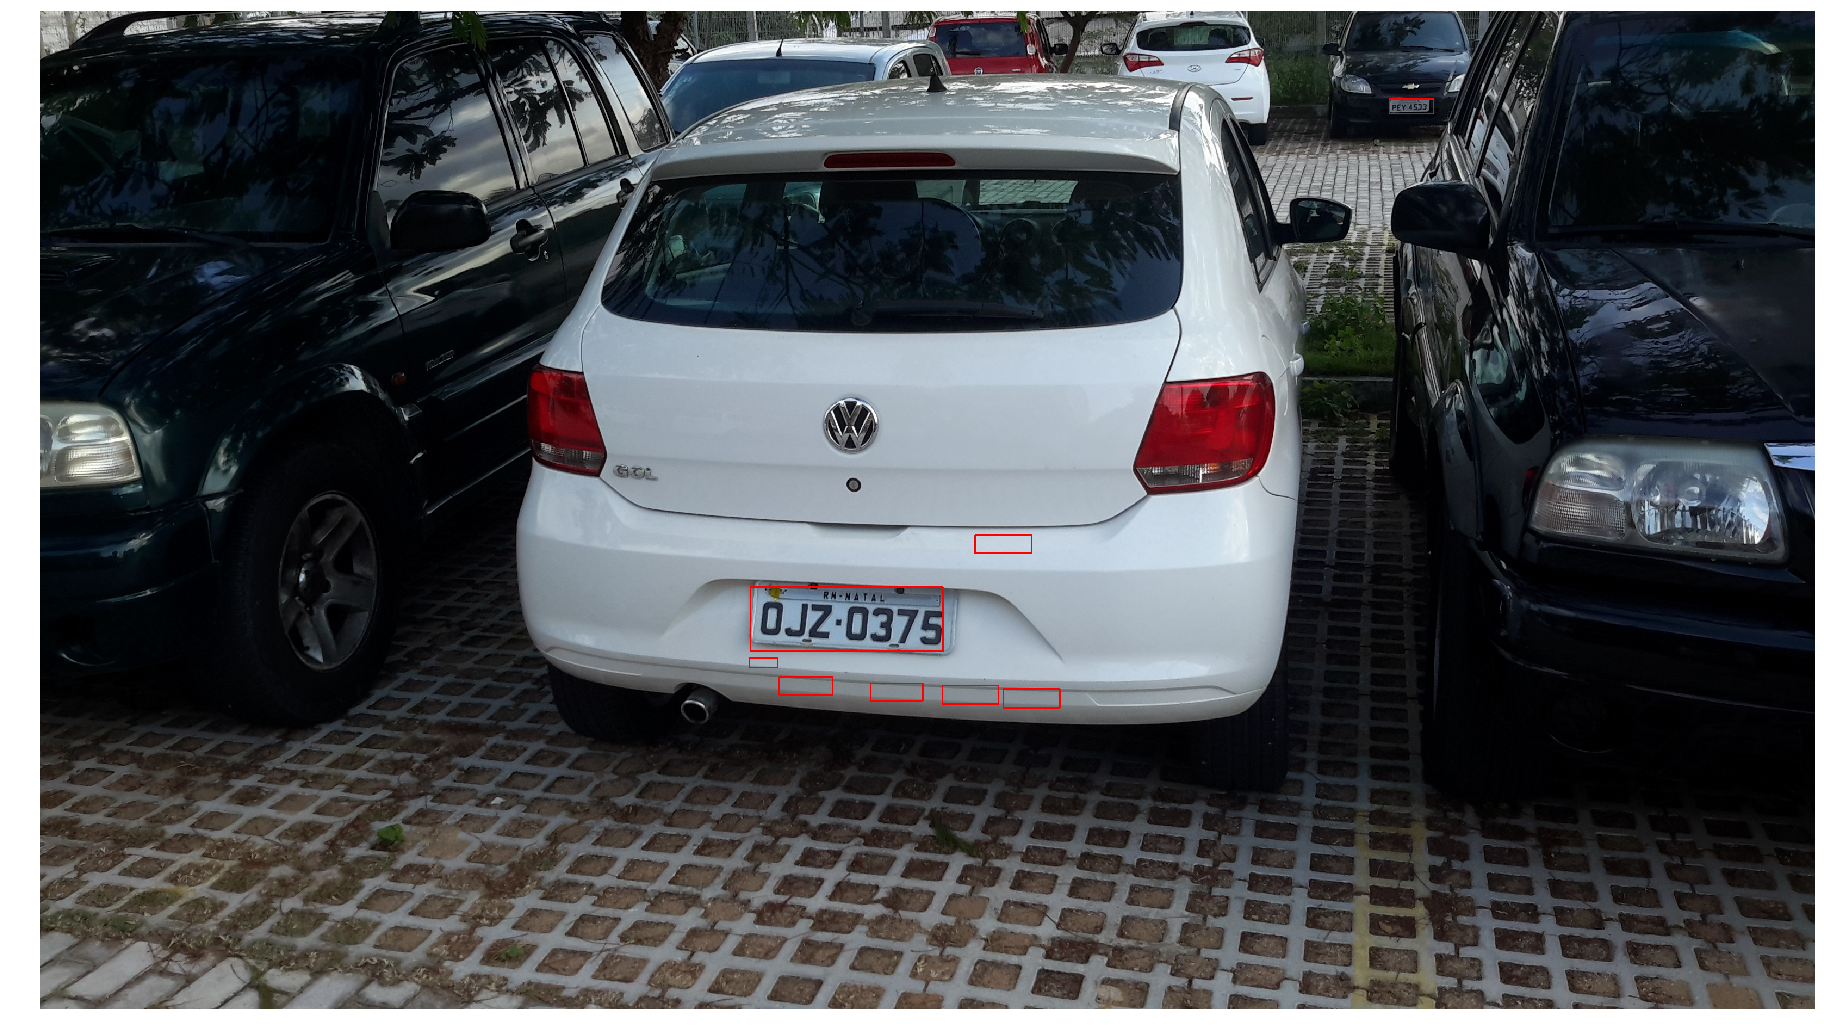

In [89]:
# Drawing rects around detected plates
car_cp = car.copy()

for (x,y,w,h) in plates:
    cv2.rectangle(car_cp,(x,y),(x+w,y+h),(255,0,0),2)

dpi = 100
height, width = car.shape[:2]

figsize = width / dpi, height / dpi

# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(car_cp)
plt.show()

Now, as we already know our ```plates```, we will try to segment the characters of the plates. Now, we have to crop the plates from original image.

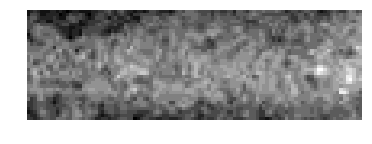

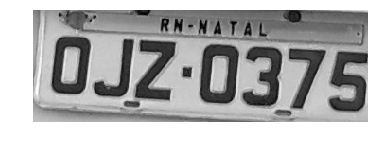

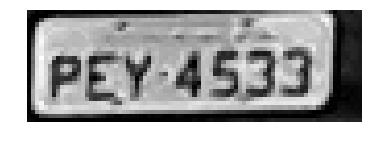

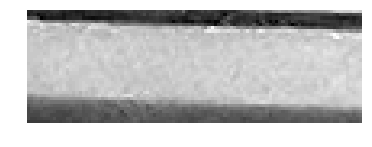

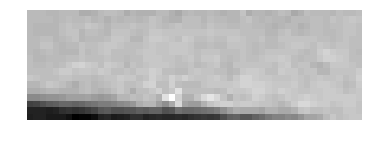

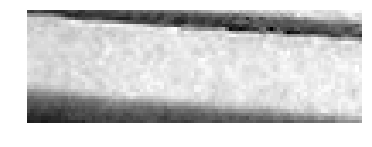

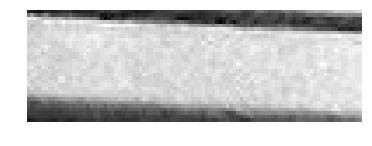

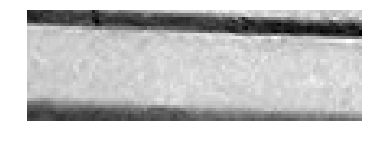

In [95]:
# Creating the list to store our plates
fig_plates = []
fig_plates_ngray = []

# Adding plates to the list
for (x,y,w,h) in plates:
    fig_plates.append( car_gray[y : y + h, x : x + w] )
    fig_plates_ngray.append( car[y : y + h, x : x + w] )

# Knowing the plates
for p in fig_plates:
    plt.figure()
    plt.axis("off")
    plt.imshow(p, cmap='gray')
    plt.show()

After that, let's to *binarize* the plates using **adaptative thresholding**.

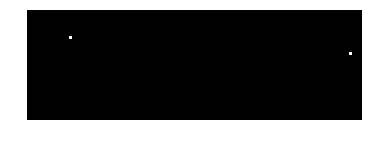

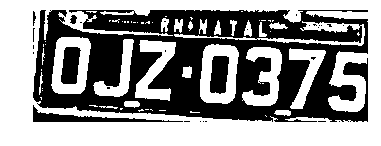

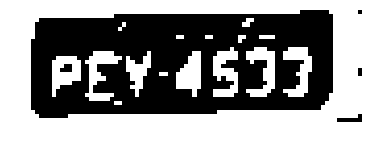

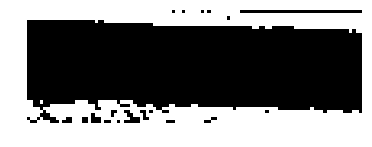

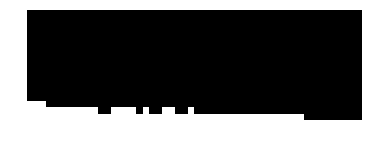

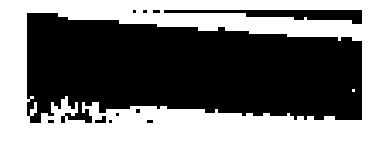

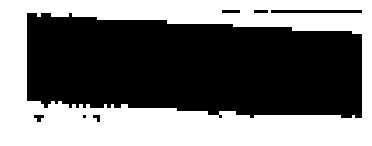

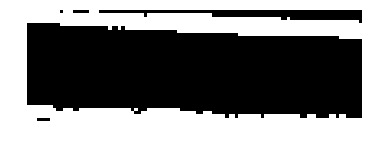

In [91]:
binary_plates = []

for i in range(0, len(fig_plates)):
    binary_plates.append(cv2.adaptiveThreshold(fig_plates[i], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 17, 5))

for p in binary_plates:
    plt.figure()
    plt.axis("off")
    plt.imshow(p, cmap='gray')
    plt.show()

# 2 - Classification
## 2.1) Connected components

This is the moment for we segment the letters of the plates, and this operation is possible by the use of connected components analysis. It is an algorithmic application of graph theory, where subsets of connected components are uniquely labeled based on a given heuristic and is used to detect connected regions in binary digital images. [3]

With OpenCV, we can use the following function:

<center>
    <strong>cv2.connectedComponentsWithStats(image, connectivity, ltype) </strong>
</center>

where:

<ul>
    <li><i>image</i> – The 8-bit single-channel image to be labeled.</li>
    <li><i>connectivity</i> – 8 or 4 for 8-way or 4-way connectivity respectively.</li>
    <li><i>ltype</i> – Output image label type. Currently CV_32S and CV_16U are supported.</li>
</ul>

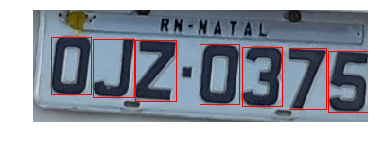

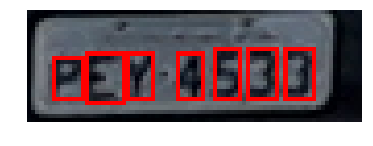

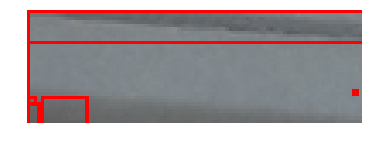

In [101]:
# Auxiliary function
def euclidean(p, q):
    if len(p) != len (q):
        return -1
    
    local_sum = 0
    for i in range(0, len(p)):
        local_sum += pow(q[i] - p[i], 2)
    
    return sqrt (local_sum)

# Trying to segment our plates
for p in range(0, (len(binary_plates) - 1)):
    output = cv2.connectedComponentsWithStats(binary_plates[p], 8, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    
    if num_labels < 7:
        continue
        
    # Filtering by area
    labels_area = []
    
    for label in range(0, num_labels - 1):
        labels_area.append( (stats[label, cv2.CC_STAT_AREA], label) )
    
    labels_area = sorted(labels_area)
    
    # Choosing the 10 biggest
    if len(labels_area) < 10:
        labels_area = [label[1] for label in labels_area]
    else:
        labels_area = [label[1] for label in labels_area[len(labels_area) - 10 : len(labels_area)]]
    
    # Filtering by mean of width    
    labels_width = []
    mean_width = 0
    
    for label in labels_area:
        mean_width += stats[label, cv2.CC_STAT_WIDTH]
        labels_width.append( (stats[label, cv2.CC_STAT_WIDTH], label) )
    
    mean_width = mean_width / len(labels_area)
    
    for label in range(0, (len(labels_width) - 1)):
        labels_width[label] = (euclidean([mean_width], [labels_width[label][0]]), labels_width[label][1])
    
    labels_width = sorted(labels_width)
    final_labels = [label[1] for label in labels_width[:7]]
    
    # Drawing the result
    result = fig_plates_ngray[p].copy()
    
    for label in final_labels:
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        x = stats[label, cv2.CC_STAT_LEFT]
        y = stats[label, cv2.CC_STAT_TOP]
        cv2.rectangle(result,(x,y),(x+width,y+height),(255,0,0),1)
    
    plt.figure()
    plt.axis("off")
    plt.imshow(result)
    plt.show()
    

# References

[1] OpenCV: Face Detection using Haar Cascades. 2018. OpenCV: Face Detection using Haar Cascades. [ONLINE] Available at: https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html. [Accessed 04 May 2018].

[2] Cascade Classification — OpenCV 2.4.13.6 documentation. 2018. Cascade Classification — OpenCV 2.4.13.6 documentation. [ONLINE] Available at: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html. [Accessed 04 May 2018].

[3] Connected-component labeling - Wikipedia. 2018. Connected-component labeling - Wikipedia. [ONLINE] Available at: https://en.wikipedia.org/wiki/Connected-component_labeling. [Accessed 04 May 2018].